# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 
В распоряжении имеется набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.resnet import ResNet50


import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_train(path): 
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345)
 
    return train_datagen_flow 

def load_test(path): 
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255, horizontal_flip=True) 
    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe = labels, 
            directory = path + 'final_files', 
            x_col='file_name', 
            y_col='real_age', 
            target_size=(224, 224), 
            batch_size=32, 
            class_mode='raw', 
            subset = 'validation', 
            seed=12345) 
 
    return test_datagen_flow

In [3]:
train_datagen_flow = load_train('/datasets/faces/')

Found 7591 validated image filenames.


In [4]:
test_datagen_flow = load_test('/datasets/faces/')

Found 1897 validated image filenames.


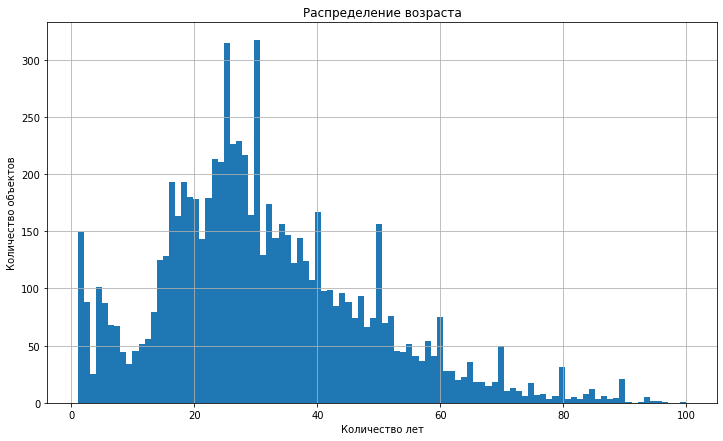

In [13]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels['real_age'].hist(bins=100, figsize=(12, 7))
plt.xlabel('Количество лет')
plt.ylabel('Количество объектов')
plt.title('Распределение возраста')
plt.show()

На распределении видны заметные пики на ровных десятках, они могли возникнуть из-за неточностей в разметке фотографий, а также округления возраста.

Построим график квантиль-квантиль для проверки распределения на нормальность.

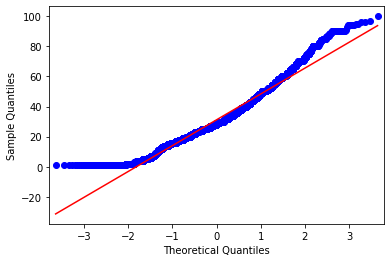

In [6]:
qqplot(labels['real_age'], line='s')
plt.show()

Проверим распределение на нормальность с помощью критерия Шапиро-Уилка.

Сформулируем нулевую гипотезу:
* H0 - Распределение похоже на нормальное, тогда
* H1 - Распределение не похоже на нормальное.

In [7]:
stat, p = shapiro(labels['real_age'])
print('Статистика=%.3f, p=%.10f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Распределение похоже на нормальное (не получилось отклонить H0)')
else:
    print('Распределение не похоже на нормальное (отклоняем H0)')

Статистика=0.965, p=0.0000000000
Распределение не похоже на нормальное (отклоняем H0)


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [8]:
features, target = next(train_datagen_flow)
features.shape

(32, 224, 224, 3)

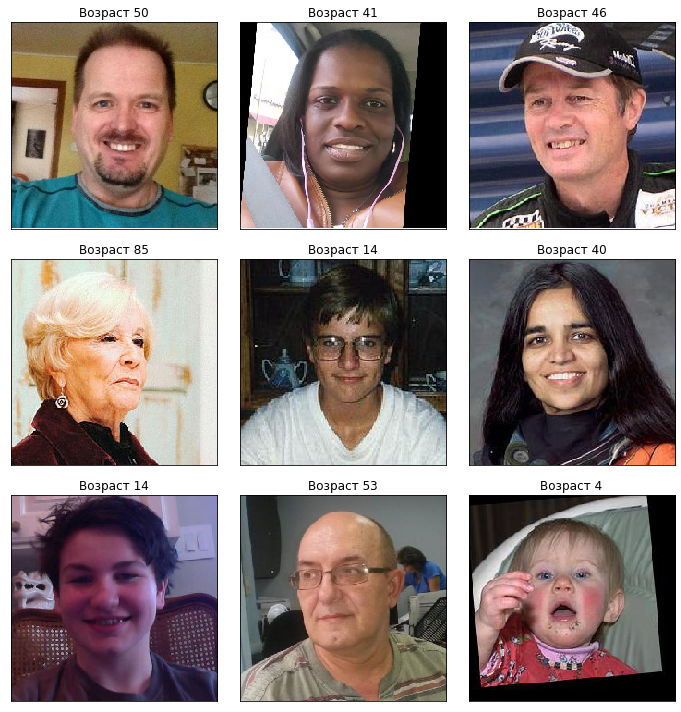

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст ' + str(target[i]))

### Вывод

Имеется выборка, состоящая из 9488 фотографий для обучения модели, 
которую мы разделили на обучающую и валидационную в соотношении 1:4.

График кванитиль-квантиль показывает заметные отклонения распределения от нормального.

С помощью критерия Шапиро-Уилка мы отклонили нулевую гипотезу о нормальности распределения 
(со значением p < 0.000).

Выборка имеет бимодальное распределение, с вершинами около 0 и 30 лет. 
Соответственно, данное распределение может существенно повлиять на результаты обучения итоговой модели. 
Модель может переобучиться на более частотных данных и недообучиться для менее частотных возрастов.

## Обучение модели

запуск на GPU

```python

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path): 
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1/255, horizontal_flip=True) 
    train_datagen_flow = train_datagen.flow_from_dataframe( 
            dataframe = labels, 
            directory = path + 'final_files', 
            x_col='file_name', 
            y_col='real_age', 
            target_size=(224, 224), 
            batch_size=32, 
            class_mode='raw', 
            subset = 'training', 
            seed=12345) 

    return train_datagen_flow 
 
def load_test(path): 
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1/255, horizontal_flip=True) 
    test_datagen_flow = test_datagen.flow_from_dataframe( 
            dataframe = labels, 
            directory = path + 'final_files', 
            x_col='file_name', 
            y_col='real_age', 
            target_size=(224, 224), 
            batch_size=32, 
            class_mode='raw', 
            subset = 'validation', 
            seed=12345) 

    return test_datagen_flow
	
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
	
    backbone = ResNet50(input_shape=input_shape,           weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
					include_top=False)
    backbone.trainable = True
	
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
	
    model.compile(loss='mae', optimizer=optimizer,
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
                
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10

178/178 - 69s - loss: 10.6364 - mae: 10.6294 - val_loss: 20.7298 - val_mae: 20.7265
Epoch 2/10
178/178 - 37s - loss: 7.0727 - mae: 7.0726 - val_loss: 18.7925 - val_mae: 18.7596
Epoch 3/10
178/178 - 37s - loss: 6.1864 - mae: 6.1869 - val_loss: 11.3831 - val_mae: 11.3343
Epoch 4/10
178/178 - 37s - loss: 5.5512 - mae: 5.5510 - val_loss: 7.7302 - val_mae: 7.7475
Epoch 5/10
178/178 - 37s - loss: 4.9857 - mae: 4.9862 - val_loss: 7.3562 - val_mae: 7.3750
Epoch 6/10
178/178 - 38s - loss: 4.5459 - mae: 4.5461 - val_loss: 6.2571 - val_mae: 6.2780
Epoch 7/10
178/178 - 37s - loss: 4.2646 - mae: 4.2647 - val_loss: 6.3389 - val_mae: 6.3426
Epoch 8/10
178/178 - 38s - loss: 3.9831 - mae: 3.9833 - val_loss: 6.3642 - val_mae: 6.3802
Epoch 9/10
178/178 - 37s - loss: 3.6911 - mae: 3.6911 - val_loss: 6.1248 - val_mae: 6.1406
Epoch 10/10
178/178 - 37s - loss: 3.4334 - mae: 3.4339 - val_loss: 6.1215 - val_mae: 6.1394
    to  
  ['...']
60/60 - 9s - loss: 6.1797 - mae: 6.1822
Test MAE: 6.1822

```

## Анализ обученной модели

### Вывод

Для обучения модели мы использовали архитектуру сети ResNet50, 
позволяющая наиболее быстро добиться оптимальных результатов метрики.

Значение метрики MAE на валидационной выборке составило 6.18, это позволяет:

* предсказать приблизительный возраст покупателей и довольно точно составить подходящую группу товаров для рекомендации;
* использовать модель в качестве дополнительного контроля добросовестности продавцов.